In [296]:
import os
import decimal
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def merge_nonbuilder_latencies(latency_files, node_type):
    """
    Merge all validator latency files into one dataframe
    """
    
    latency_dfs = []
    for latency_file in latency_files:
        latency_df = pd.read_csv(latency_file)
        latency_df['filename'] = latency_file.replace("_latency_stats_" +node_type+ ".csv", "")
        latency_df["node_type"] = node_type
        latency_df['block_id'] = range(len(latency_df))
        latency_df = latency_df[ ["node_type", "filename", "block_id", "Total Sampling Latency (us)"] ]
        
        latency_dfs.append(latency_df)

    return pd.concat(latency_dfs)

def get_nonbuilder_df(latency_files, node_type):
    latency_df = merge_nonbuilder_latencies(latency_files, node_type)
    latency_df['Latency (s)'] = latency_df['Total Sampling Latency (us)'] / 1_000_000
    latency_df = latency_df[ ["node_type", "filename", "block_id", "Latency (s)"] ]

    return latency_df

def get_latency_files(node_type):
    if node_type == "builder":
        return [file for file in os.listdir() if file.endswith('builder.csv') and "latency_stats" in file.lower()][0]
    else:
        return [file for file in os.listdir() if file.endswith('_' +node_type+ '.csv') and "latency_stats" in file.lower()]

def get_total_putgets(node_id, node_type):
    total_stats_files = [file for file in os.listdir() if node_id in file and 'total_stats' in file.lower()]
    
    total_stats_file = total_stats_files[0]

    total_stats_df = pd.read_csv(total_stats_file)

    if node_type == "builder":
        total_putgets = total_stats_df['Total PUT messages'][0]
        failed_putgets = total_stats_df['Total failed PUTs'][0]
    else:
        total_putgets = total_stats_df['Total GET messages'][0]
        failed_putgets = total_stats_df['Total failed GETs'][0]

    return total_putgets, failed_putgets

def get_total_stats(latency_df):
    for index, row in latency_df.iterrows():
        total_putgets, failed_putgets = get_total_putgets(row['filename'], row['node_type'])
        success_putgets = total_putgets - failed_putgets
        latency_df.loc[index, 'Total PUT/GETs'] = total_putgets
        latency_df.loc[index, 'Successful PUT/GETs'] = success_putgets

    return latency_df

def get_operations():
    # Get the operation files for each node
    operation_files = [file for file in os.listdir() if file.endswith(".csv") and "operations" in file.lower() and "putget_operations.csv" not in file.lower()]
    
    operations_df = pd.DataFrame()

    for operation_file in operation_files:
        operation_df = pd.read_csv(operation_file)
        
        nan_count = operation_df['Block ID'].isna().sum()
        if nan_count > 0:
            before = len(operation_df)
            # Remove any rows with NaN values in the Block ID column
            operation_df = operation_df.dropna(subset=['Block ID'])
            after = len(operation_df)
            print("Removed " + str(before - after) + " rows with NaN values from " + operation_file)

        operation_df['node_id'] = operation_file.split("_")[0]
        operation_df['node_type'] = operation_file.split("_")[2].replace(".csv", "")
        operation_df['timestamps'] = pd.to_datetime(operation_df['PUT timestamps'].fillna(operation_df['GET timestamps']), format='%H:%M:%S.%f')
        operation_df['latencies_us'] = operation_df['PUT latencies'].fillna(operation_df['GET latencies'])
        operation_df['Block ID'] = operation_df['Block ID'].astype(int)
        operation_df['Block ID'] = operation_df['Block ID'] + 1

        operations_df = pd.concat([operations_df, operation_df])

    # # Find the minimum timestamp for each node_type
    # min_timestamps = operations_df.groupby('node_type')['timestamps'].min()

    # # Calculate the time offset for each node_type to synchronize them
    # offsets = min_timestamps - min_timestamps.min()

    # # Apply the time offset to synchronize timestamps
    # operations_df['synced_timestamps'] = operations_df['timestamps']
    # operations_df['synced_timestamps'] -= operations_df['node_type'].map(offsets)

    # # Convert the synchronized timestamps back to the original format
    # operations_df['synced_timestamps'] = operations_df['synced_timestamps'].dt.strftime('%H:%M:%S.%f')

    # # Calculate the elapsed duration in nanoseconds
    # operations_df['synced_elapsed_duration_ms'] = operations_df['synced_timestamps'].apply(lambda x: pd.to_timedelta(x).total_seconds() * 1e6)
    # operations_df['elapsed_duration_ms'] = operations_df['timestamps'].apply(lambda x: pd.to_timedelta(str(x).replace('-', '')).total_seconds() * 1e6)

    # # Take the minimum duration from all elapsed durations to reset to 0 as the starting point
    # min_duration = operations_df['synced_elapsed_duration_ms'].min()
    # operations_df['synced_elapsed_duration_ms'] -= min_duration
    # min_duration = operations_df['elapsed_duration_ms'].min()
    # operations_df['elapsed_duration_ms'] -= min_duration

    # Convert timestamps to pd.Timestamp
    operations_df['timestamps'] = pd.to_datetime(operations_df['timestamps'], format='%Y-%m-%d %H:%M:%S.%f')

    # Convert the parcel key hash hexadecimal string into an integer
    operations_df['Parcel Key Hash Int'] = operations_df['Parcel Key Hashes'].apply(lambda x: int(x, 16))
    
    # Delete the PUT/GET timestamps and latencies columns
    operations_df = operations_df.drop(columns=['PUT timestamps', 'PUT latencies', 'GET timestamps', 'GET latencies', 'GET hops'])

    # Remove data for the first and last block id
    operations_df = operations_df[(operations_df['Block ID'] != 1) & (operations_df['Block ID'] != operations_df['Block ID'].max())]

    row_count_before = len(operations_df)
    # Remove any rows with NaN values
    operations_df = operations_df.dropna()
    row_count_after = len(operations_df)
    print("Removed " + str(row_count_before - row_count_after) + " rows with NaN values from operations_df")

    grouped_op_df = operations_df.groupby('Block ID')
    for block_id, block_df in grouped_op_df:
        block_case_count = 0
        total_count = 0
        block_df['Parcel Key Hash Int'] = block_df['Parcel Key Hash Int'].apply(decimal.Decimal)
        for hash_int, hash_int_df in block_df.groupby("Parcel Key Hash Int"):
            node_count = len(hash_int_df)

            if node_count == 1:
                continue

            earliest_timestamp = hash_int_df['timestamps'].min()
            earliest_node_type = hash_int_df[hash_int_df['timestamps'] == earliest_timestamp]['node_type'].values[0]

            # Is the earliest timestamp from a non builder node?

            if node_count > 1 and earliest_node_type != "builder":
                # get the rows with the hash_int value and set the parcel status as premature
                operations_df.loc[
                    (operations_df['Parcel Key Hash Int'] == hash_int) & 
                    (operations_df['node_type'] != "builder") & 
                    (operations_df['Parcel Status'] != "timeout"), 
                    'Parcel Status'
                ] = 'premature'
                # print("Block " + str(block_id) + " Parcel Key Hash Int " + str(hash_int) + " has " + str(node_count) + " nodes with earliest timestamp from " + earliest_node_type)
                block_case_count += 1

            total_count += 1

        if block_case_count > 0:
            print("Block " + str(block_id) + " has " + str(block_case_count) + " premature cases out of " + str(total_count) + " ")

    operations_df.to_csv("putget_operations.csv", index=False)

    return operations_df

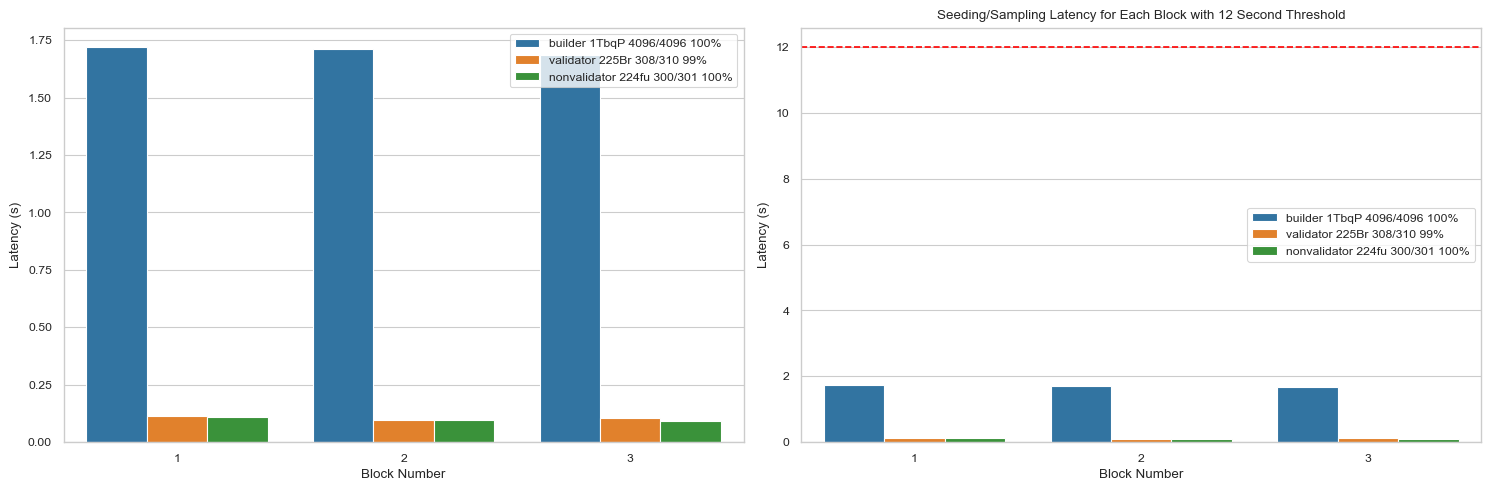

In [297]:
builder_latency_file = get_latency_files("builder")
validator_latency_files = get_latency_files("validator")
non_validator_latency_files = get_latency_files("nonvalidator")

validator_latency_df = get_nonbuilder_df(validator_latency_files, "validator")
non_validator_latency_df = get_nonbuilder_df(non_validator_latency_files, "nonvalidator")

validator_latency_df = get_total_stats(validator_latency_df)
non_validator_latency_df = get_total_stats(non_validator_latency_df)

# Get builder latency stats
builder_latency_df = pd.read_csv(builder_latency_file)
builder_latency_df['Latency (s)'] = builder_latency_df['Seeding Latency (us)'] / 1_000_000
builder_latency_df['filename'] = builder_latency_file.replace("_latency_stats_builder.csv", "")
builder_latency_df['block_id'] = range(len(builder_latency_df))
builder_latency_df["node_type"] = "builder"
builder_latency_df = builder_latency_df[ ["node_type", "filename", "block_id", "Latency (s)"] ]
builder_latency_df = get_total_stats(builder_latency_df)

# Merge all latency stats
latency_df = pd.concat([builder_latency_df, validator_latency_df, non_validator_latency_df])
latency_df['node_label'] = latency_df['node_type'] + " " + latency_df['filename'].apply(lambda x: x[:5])
latency_df['Successful PUT/GETs'] = latency_df['Successful PUT/GETs'].astype(int)
latency_df['Total PUT/GETs'] = latency_df['Total PUT/GETs'].astype(int)
latency_df['Successful/Total Label'] = latency_df['Successful PUT/GETs'].astype(str) + '/' + latency_df['Total PUT/GETs'].astype(str)
latency_df['Percentage'] = (latency_df['Successful PUT/GETs'] / latency_df['Total PUT/GETs'] * 100).round().astype(int)
latency_df['node_label'] = latency_df['node_label'] + " " + latency_df['Successful/Total Label'].astype(str) + " " + latency_df['Percentage'].astype(str) + "%"

# Remove first and last block
latency_df = latency_df[ (latency_df['block_id'] != 0) & (latency_df['block_id'] != len(builder_latency_df)) ]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ax = axes[0]
plt.title("Seeding/Sampling Latency for Each Block")
sns.barplot(x="block_id", y="Latency (s)", hue="node_label", data=latency_df, ax=ax)
ax.set_xlabel("Block Number")
ax.set_ylabel("Latency (s)")
ax.legend()

ax = axes[1]
plt.title("Seeding/Sampling Latency for Each Block with 12 Second Threshold")
sns.barplot(x="block_id", y="Latency (s)", hue="node_label", data=latency_df, ax=ax)
ax.set_xlabel("Block Number")
ax.set_ylabel("Latency (s)")
ax.axhline(y=12, color='red', linestyle='--')
ax.legend()

plt.tight_layout()
plt.show()

Removed 0 rows with NaN values from operations_df
Block 2 has 141 premature cases out of 1024 
Block 3 has 138 premature cases out of 1024 


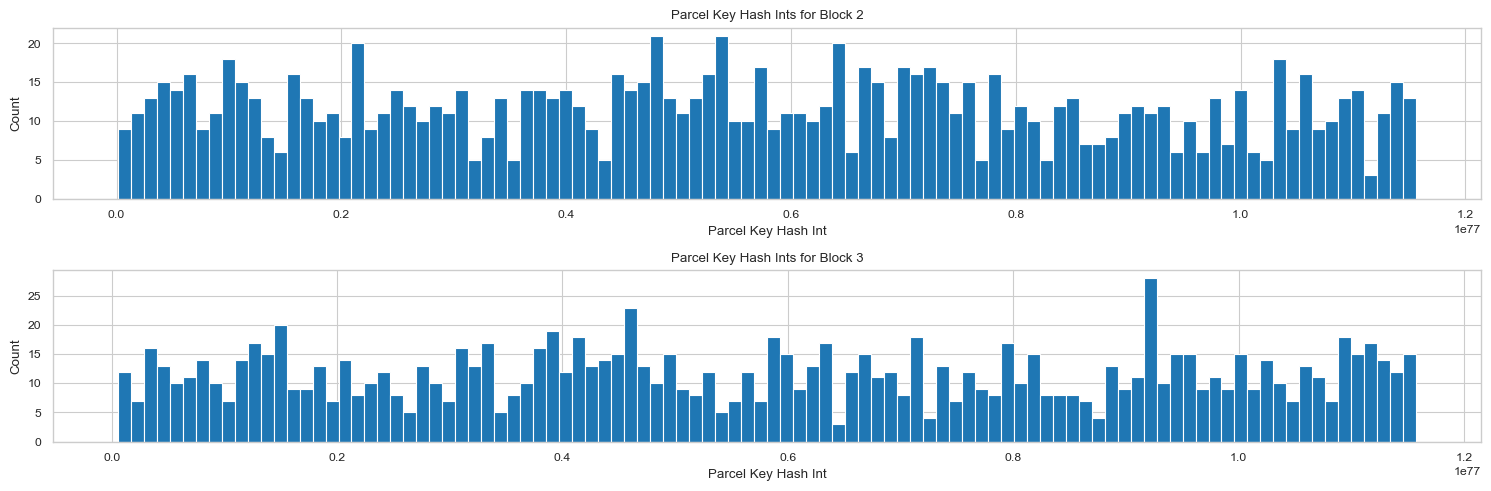

In [280]:
grouped_op_df = get_operations().groupby("Block ID")

fig, axes = plt.subplots(len(grouped_op_df), 1, figsize=(15, 5))

for block_id, block_df in grouped_op_df:
    parcel_hash_ints = block_df['Parcel Key Hash Int']
    parcel_hash_ints = parcel_hash_ints[parcel_hash_ints != -1]
    parcel_hash_ints = parcel_hash_ints.apply(decimal.Decimal)

    ax = axes[block_id - 2]
    ax.set_title("Parcel Key Hash Ints for Block " + str(block_id))
    ax.hist(parcel_hash_ints, bins=100)
    ax.set_xlabel("Parcel Key Hash Int")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

Removed 0 rows with NaN values from operations_df
Block 2 has 141 premature cases out of 142 
Block 3 has 138 premature cases out of 139 


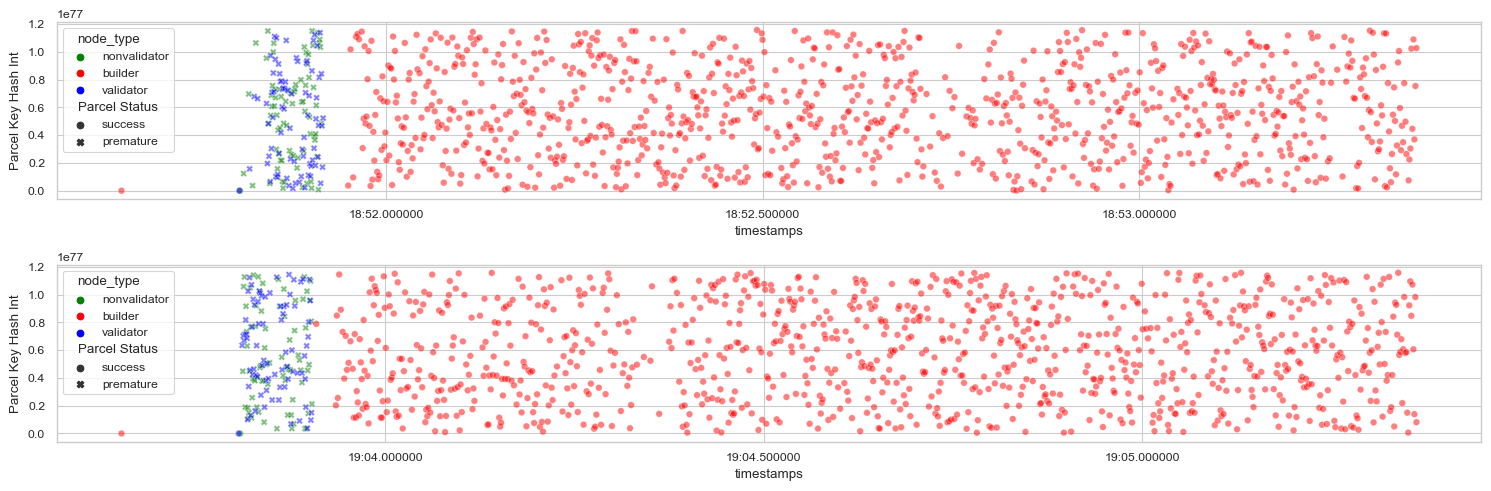

In [298]:
grouped_op_df = get_operations().groupby("Block ID")

fig, axes = plt.subplots(len(grouped_op_df), 1, figsize=(15, 5))

colours = {
    "builder": "red",
    "validator": "blue",
    "nonvalidator": "green"
}

for block_id, block_df in grouped_op_df:
    block_df['Parcel Key Hash Int'] = block_df['Parcel Key Hash Int'].apply(decimal.Decimal)
    block_df['timestamps'] = pd.to_datetime(block_df['timestamps'])

    block_df_grouped_by_nodetype = block_df.groupby("node_type")

    ax = axes[block_id - 2]
    sns.scatterplot(
        x="timestamps", 
        y="Parcel Key Hash Int", 
        hue="node_type",
        style="Parcel Status",
        palette=colours,
        data=block_df, 
        ax=ax,
        alpha=0.5
    )

plt.tight_layout()

In [ ]:
putget_operations_df = get_operations()
block_ids = putget_operations_df['Block ID'].unique()
putget_operations_df = putget_operations_df[ (putget_operations_df['Block ID'] != 1) & (putget_operations_df['Block ID'] != len(block_ids)) ]
putget_operations_df.to_csv("putget_operations.csv", index=False)

sns.set_style("whitegrid")
sns.set_context("paper")

new_block_ids_count = len(block_ids) - 2
fig, axes = plt.subplots( new_block_ids_count + 1 , 2, figsize=(20, 4*(new_block_ids_count)) )
putget_operations_df_grouped = putget_operations_df.groupby("Block ID")

hues = {
    "builder": "green",
    "validator": "orange",
    "nonvalidator": "purple"
}

for block_id, block_df in putget_operations_df_grouped:
    block_id_index = block_id - 2

    ax = axes[block_id_index, 0]
    x_col = "synced_elapsed_duration_ms"

    sns.scatterplot(x=x_col, y="Parcel ID", hue="node_type", data=block_df, ax=ax, alpha=0.3, palette=hues, style="Parcel Status")

    # Plot the starting signal vertical lines
    starting_signal_df = block_df[block_df['Parcel ID'] == -1]

    for index, row in starting_signal_df.iterrows():
        if row['node_type'] == "builder":
            ax.axvline(x=row[x_col], color='green', linestyle='--', alpha=0.5)
        elif row['node_type'] == "validator":
            ax.axvline(x=row[x_col], color='orange', linestyle='--', alpha=0.5)
        elif row['node_type'] == "nonvalidator":
            ax.axvline(x=row[x_col], color='purple', linestyle='--', alpha=0.5)

    ax.set_title("PUT/GET Operations for Block " + str(block_id))
    ax.set_xlabel("Elapsed Duration (ms)")
    # ax.set_xticks([])
    # ax.set_xticklabels([])
    ax.set_ylabel("Parcel ID")
    ax.legend(loc='upper right')

    # Plot distribution of parcel IDs
    axes[block_id_index, 1].hist(block_df["Parcel ID"], bins=100, color='blue', alpha=0.5)
    axes[block_id_index, 1].set_title("Distribution of Parcel IDs for Block " + str(block_id))
    axes[block_id_index, 1].set_xlabel("Parcel ID")
    # axes[block_id_index, 1].set_xticks(range(0, max(block_df["Parcel ID"]), 10_000))
    # axes[block_id_index, 1].set_xticklabels(range(0, max(block_df["Parcel ID"]), 10_000), rotation=90)
    # axes[block_id_index, 1].set_xlim(0, 10_000)
    axes[block_id_index, 1].set_ylabel("Frequency")

i = new_block_ids_count
ax = axes[i, 0]
plt.title("Seeding/Sampling Latency for Each Block")
sns.barplot(x="block_id", y="Latency (s)", hue="node_label", data=latency_df, ax=ax)
ax.set_xlabel("Block Number")
ax.set_ylabel("Latency (s)")
ax.legend()

i = new_block_ids_count
ax = axes[i, 1]
plt.title("Seeding/Sampling Latency for Each Block with 12 Second Threshold")
sns.barplot(x="block_id", y="Latency (s)", hue="node_label", data=latency_df, ax=ax)
ax.set_xlabel("Block Number")
ax.set_ylabel("Latency (s)")
ax.axhline(y=12, color='red', linestyle='--')
ax.legend()

plt.tight_layout()
plt.show()